In [1]:
import os
import numpy as np
import reading 
from feature_extractor import feature_extractor
import pandas as pd
import matplotlib.pyplot as plt

Load dei Path, Con il sort giusto per far corrispondere i soggetti

In [2]:
paths_MD= reading.data_path("Diffusion_parameters_maps-20230215T134959Z-001","corrected_MD_image")
paths_masks=reading.data_path("Diffusion_space_segmentations-20230215T134839Z-001","Diffusion_space_segmentations-20230215T134839Z-001")


#print((os.path.basename(paths_masks[0]).split('_')[2]))

paths_MD.sort(key=lambda x: int(os.path.basename(x).split('_')[3]))
paths_masks.sort(key=lambda x: int(os.path.basename(x).split('_')[2]))


Feature extraction

In [3]:
region, mean, std=feature_extractor(paths_MD,paths_masks)


Reshape degli array per fare il Dataframe

In [4]:
mean_t=np.transpose(mean)
std_t=np.transpose(std)


Creo DataFrame per mean and std

In [5]:


df_mean = pd.DataFrame(mean_t[1:,1:177],index=mean[0][1:98],columns=region[1:177])
df_std=pd.DataFrame(std_t[1:,1:177],index=std[0][1:98],columns=region[1:177])

df_mean.head()

,Left-Lateral-Ventricle,Left-Inf-Lat-Vent,Left-Cerebellum-White-Matter,Left-Cerebellum-Cortex,Left-Thalamus,Left-Caudate,Left-Putamen,Left-Pallidum,3rd-Ventricle,4th-Ventricle,...,wm-rh-superiorfrontal,wm-rh-superiorparietal,wm-rh-superiortemporal,wm-rh-supramarginal,wm-rh-frontalpole,wm-rh-temporalpole,wm-rh-transversetemporal,wm-rh-insula,Left-UnsegmentedWhiteMatter,Right-UnsegmentedWhiteMatter
1.0,0.000078,0.002625,0.001393,0.000837,0.001063,0.001086,0.001244,0.000855,0.000820,0.002566,...,0.000842,0.000906,0.000964,0.000797,0.000786,0.000848,0.000919,0.000736,0.000898,0.000931
2.0,0.000093,0.002450,0.001338,0.000724,0.000878,0.000953,0.000986,0.000773,0.000768,0.002419,...,0.000781,0.000774,0.000912,0.000757,0.000752,0.000778,0.000838,0.000749,0.000785,0.000865
3.0,0.000135,0.002526,0.001711,0.000716,0.000955,0.001038,0.001291,0.000905,0.000885,0.002576,...,0.000813,0.000848,0.000803,0.000822,0.000763,0.001048,0.001090,0.000780,0.000910,0.000919
4.0,0.000144,0.002553,0.001665,0.000769,0.001031,0.001050,0.001144,0.000818,0.000747,0.003102,...,0.000830,0.000848,0.000819,0.000839,0.000820,0.000873,0.000873,0.000820,0.000859,0.000903
5.0,0.000142,0.002536,0.001829,0.000781,0.001109,0.000991,0.001134,0.000794,0.000748,0.002780,...,0.000835,0.000823,0.000748,0.000813,0.000765,0.000848,0.000963,0.000766,0.000861,0.000891


Aggiungo i gruppi

In [6]:
a=pd.DataFrame(pd.read_csv('/home/francesco/CompProject/ADNI_dataset_diffusion.csv'))
a.sort_values(by=["Subject"],inplace=True)
group=a["Group"]
a.head()

,Subject,Group,Sex,Age
67,4002,0,F,74.0
68,4003,0,F,72.0
28,4009,1,M,90.0
69,4018,0,M,76.0
70,4050,0,M,77.0


Albero decisionale: creo i set e splitto

In [7]:

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, ConfusionMatrixDisplay
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from scipy.stats import randint


X=df_mean.values
y=group.values

X_tr, X_tst, y_tr, y_tst = train_test_split(X, y, test_size=.1, random_state=6)



Fitto l'albero

In [8]:

rf = RandomForestClassifier()
rf.fit(X_tr, y_tr)
y_pred = rf.predict(X_tst)

print(y_pred)

[0 1 1 1 0 0 0 1 0 0]


In [9]:
accuracy = accuracy_score(y_tst, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.7


Hyperparameter tuning

In [14]:
param_dist = {'n_estimators': randint(50,5000),
              'max_depth': randint(1,100)}

# Create a random forest classifier
rf = RandomForestClassifier()

# Use random search to find the best hyperparameters
rand_search = RandomizedSearchCV(rf, 
                                 param_distributions = param_dist, 
                                 n_iter=5, 
                                 cv=5)

# Fit the random search object to the data
rand_search.fit(X_tr, y_tr)

# Create a variable for the best model
best_rf = rand_search.best_estimator_

# Print the best hyperparameters
print('Best hyperparameters:',  rand_search.best_params_)


Best hyperparameters: {'max_depth': 31, 'n_estimators': 585}


In [15]:
y_pred = rand_search.predict(X_tst)

accuracy = accuracy_score(y_tst, y_pred)
precision = precision_score(y_tst, y_pred)
recall = recall_score(y_tst, y_pred)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)

Accuracy: 0.6
Precision: 0.4
Recall: 0.6666666666666666


Plotto alberi

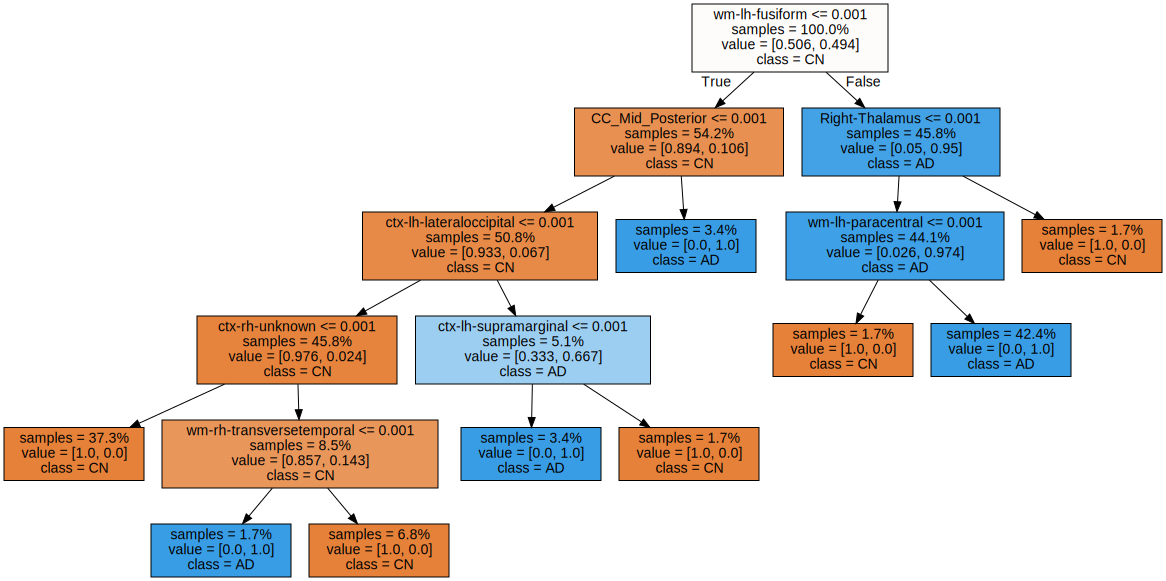

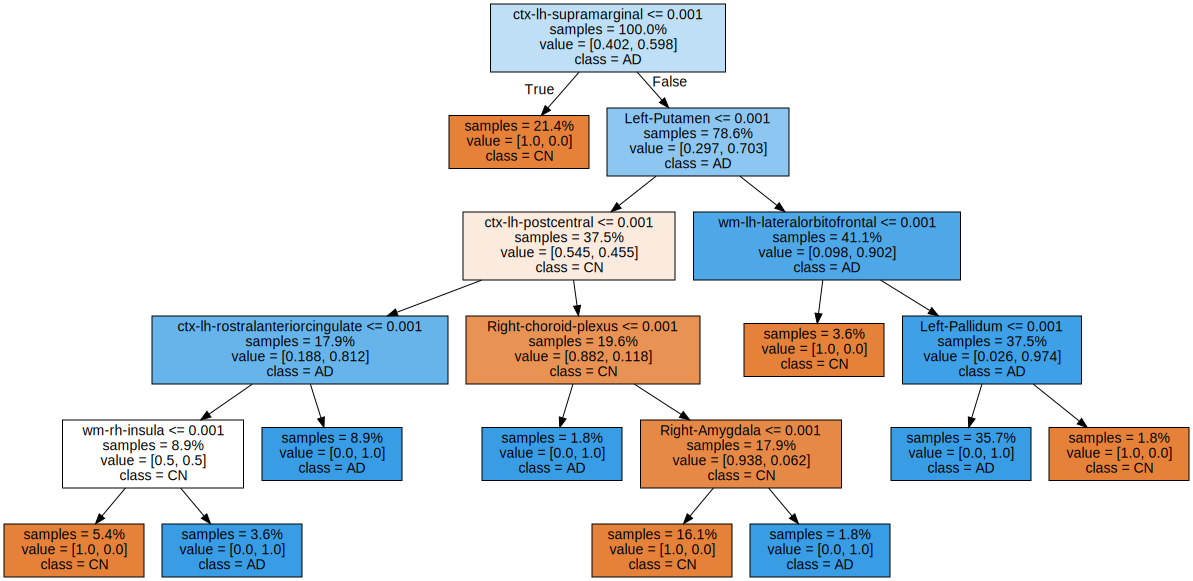

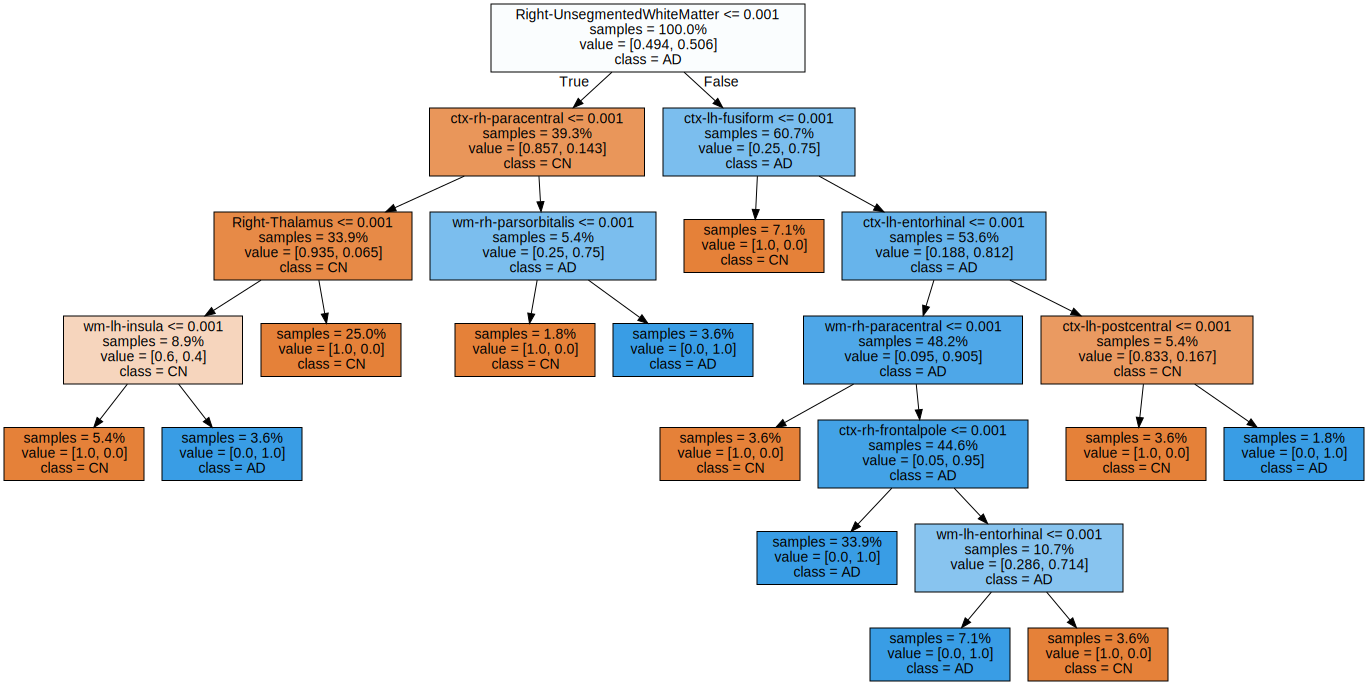

In [16]:
from sklearn.tree import export_graphviz
from IPython.display import Image
import graphviz


for i in range(3):
    tree = rand_search.best_estimator_[i]
    dot_data = export_graphviz(tree,feature_names=region[1:],  filled=True, impurity=False, proportion=True,class_names=["CN","AD"])
    graph = graphviz.Source(dot_data)
    display(graph)

ROC

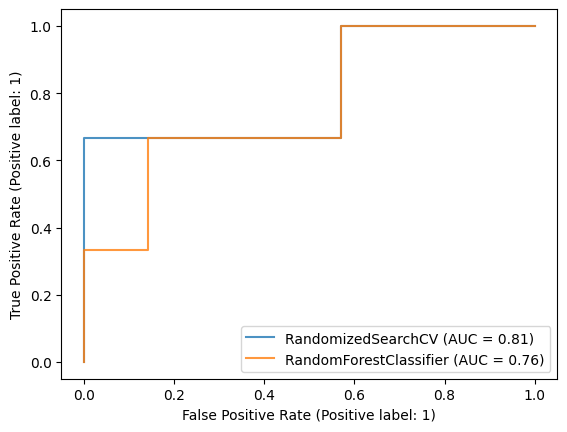

In [17]:
from sklearn.metrics import RocCurveDisplay
rf.fit(X_tr, y_tr)

ax = plt.gca()
rnds_disp = RocCurveDisplay.from_estimator(rand_search, X_tst, y_tst, ax=ax, alpha=0.8)
rndf_disp = RocCurveDisplay.from_estimator(rf, X_tst, y_tst, ax=ax, alpha=0.8)


plt.show()